## Base Backtesting Class

Specific functionality for the base backtesting class is as follows:
1. Retrieving and preparing data
2. Helper and convenience functions
3. Placing orders
4. Closing out positions

####  Retrieving and preparing data

The base class must be able to handle data retrieval and potentially preparation for backtesting. For this basic implementation, end-of-day (EOD) data from a CSV file shall be handled by the class.

####  Helper and convenience functions

Helper and convenience functions are implemented to make backtesting easier. This includes plotting data, printing state variables, or returning date and price data. 

#### Placing orders

Basic market buy and sell orders are modelled by this class.

#### Closing out positions

All positions must be closed out at the end of backtesting.

### Implementation

Before starting, some libraries are required to be imported.

In [1]:
import pandas as pd
import numpy as np

Now we can write the class

In [2]:
class BaseBacktest:
    """Class for basic event based backtesting of trading strategies.
    
    Attributes
    ==========
    symbol: str
        financial instrument to work with
    start: str
        start date for data selection
    end: str
        end date for data selection
    amount: int, float
        initial investment amount for strategy
    ftc: float
        fixed transaction cost per trade
    ptc: float
        proportional transaction cost per trade
    
    Methods
    =======
    get_data:
        retrieves and prepares data
    plot_data:
        plots the adjusted close values for the financial instrument
    print_balance:
        prints out current account cash balance
    print_net_wealth:
        prints out current account wealth (cash balance + current asset value)
    place_buy_order:
        places market buy order
    place_sell_order:
        places market sell order
    close_out:
        calculates the account net wealth at end of backtesting period. Does not close out open positions in calculation
    """
    
    
    def __init__(self, symbol, start, end, amount, ftc=0.0, ptc=0.0, verbose=True):
        

        if type(symbol) is not str:
            raise ValueError('symbol must be str')
        if type(start) is not str:
            raise ValueError('start must be str')
        if type(end) is not str:
            raise ValueError('end must be str')
        if type(amount) is not (int or float):
            raise ValueError('amount must be int or float')
        if type(ftc) is not float:
            raise ValueError('ftc must be float')
        if type(ptc) is not float:
            raise ValueError('ptc must be float')
               
        self.symbol = symbol # Set financial instrument
        self.start = start # Set start date
        self.end = end # Set end date
        self.initial_amount = amount # Store initial amount in a psuedo-private attribute
        self.amount = amount # Set starting cash balance value
        self.ftc = ftc # Define fixed transaction costs per trade (ie 1 USD per transaction)
        self.ptc = ptc # Defines proportional transaction costs per trade (ie 1% of transaction per transaction)
        self.units = 0 # Units of the instrument (ie number of shares) in the portfolio initially
        self.position = 0 # Sets initial position to market neutral
        self.trade = 0 # Sets initial number of trades to 0
        self.verbose = verbose # Set to True for full output (True by default)
        self.get_data() # Call get_data() method
    
    def __repr__(self):
        return f'BaseBacktest(symbol={self.symbol}, start={self.start}, end={self.end}, amount={self.amount}, ftc={self.ftc}, ptc={self.ptc})'
    
    def get_data(self):
        """
        Retrieves and prepares data
        """
        raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv', index_col=0, parse_dates=True).dropna()
        raw = pd.DataFrame(raw[self.symbol])
        raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: 'price'}, inplace=True)
        raw['return'] = np.log(raw / raw.shift(1))
        self.data = raw.dropna()
        
    def plot_data(self, cols=None):
        """
        Plots the closing prices for financial instrument
        """
        if cols is None:
            cols = ['Price']
        self.data['price'].plot(figsize=(10, 6), title=self.symbol)
        
    def get_date_price(self, bar):
        """
        Returns the date and price for a bar
        """
        date = str(self.data.index[bar])[:10]
        price = self.data.price.iloc[bar]
        return date, price
    
    def print_balance(self, bar):
        """
        Prints out current account cash balance
        """
        date, price = self.get_date_price(bar)
        print(f'{date} | current balance {self.amount:.2f}')
        
    def print_net_wealth(self, bar):
        """
        Prints out current account total wealth (cash balance + positions)
        """
        date, price = self.get_date_price(bar)
        net_wealth = self.units * price + self.amount
        print(f'{date} | current net wealth {net_wealth:.2f}')
        
    def place_buy_order(self, bar, units=None, amount=None):
        """
        Simulates placing a market buy order
        """
        date, price = self.get_date_price(bar)
        if units is None:
            units = int(amount / price) # Note that it is assumed the number of units is always None while the amount is amount of money to be spent buying units.
        self.amount -= (units * price) * (1 + self.ptc) + self.ftc # Note there is no liquidity checking performed.
        self.units+= units
        self.trades += 1
        if self.verbose:
            print(f'{date} | buying {units} units at {price:.2f}')
            self.print_balance(bar)
            self.print_net_wealth(bar)
            
    def place_sell_order(self, bar, units=None, amount=None):
        """
        Simulates placing a market sell order
        """
        date, price = self.get_date_price(bar)
        if units is None:
            units = int(amount / price) # As with place_buy_order, note that units is None and we are selling a set amount of wealth
        self.amount += (units * price) * (1 - self.ptc) - self.ftc
        self.units -= units
        self.trades += 1
        if self.verbose:
            print(f'{date} | selling {units} units at {price:.2f}')
            self.print_balance(bar)
            self.print_net_wealth(bar)
                       
    def close_out(self, bar):
        """
        Calculates accounts net wealth at end of backtest. 
        Does this by summing value of held assets and held cash. 
        Does not account for transaction fees required to close open positions.
        """
        date, price = self.get_date_price(bar)
        self.amount += self.units * price
        self.units = 0
        if self.verbose:
            print(f'{date} | inventory {self.units} units at {price:.2f}')
            print('=' * 55)
            print(f'Final balance [$] {self.amount:.2f}')
            performance  = ((self.amount - self.initial_amount) / self.initial_amount * 100)
            print(f'Net Performance [%] {performance:.2f}')
            print(f'Trades executed [#] {self.trades:.2f}')
            print('=' * 55)

### Testing the class

We can now make an instance of this class and test the functionality.

In [3]:
BaseBacktestInstance = BaseBacktest(symbol='AAPL.O', start='2010-1-1', end='2019-12-31', amount=100_000)

In [4]:
print(BaseBacktestInstance)

BaseBacktest(symbol=AAPL.O, start=2010-1-1, end=2019-12-31, amount=100000, ftc=0.0, ptc=0.0)


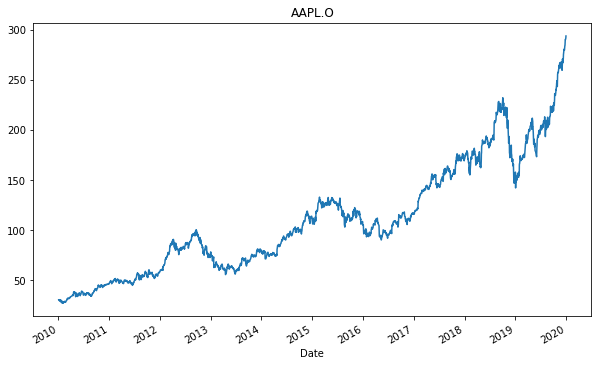

In [5]:
BaseBacktestInstance.plot_data()

### Testing with long-only mean reversion strategy

Here we demonstrate the backtesting class with a simple moving average strategy. We append an additional method to the class, *run_mean_reversion_strategy*. Observe this addition at the end of the following code block. The strategy is not the focus here, hence the lack of explaination. This serves to demonstrate the backtesting class functions as expected.

In [6]:
class BaseBacktest:
    """Class for basic event based backtesting of trading strategies.
    
    Attributes
    ==========
    symbol: str
        financial instrument to work with
    start: str
        start date for data selection
    end: str
        end date for data selection
    amount: int, float
        initial investment amount for strategy
    ftc: float
        fixed transaction cost per trade
    ptc: float
        proportional transaction cost per trade
    
    Methods
    =======
    get_data:
        retrieves and prepares data
    plot_data:
        plots the adjusted close values for the financial instrument
    print_balance:
        prints out current account cash balance
    print_net_wealth:
        prints out current account wealth (cash balance + current asset value)
    place_buy_order:
        places market buy order
    place_sell_order:
        places market sell order
    close_out:
        calculates the account net wealth at end of backtesting period. Does not close out open positions in calculation
    """
    
    
    def __init__(self, symbol, start, end, amount, ftc=0.0, ptc=0.0, verbose=True):
        

        if type(symbol) is not str:
            raise ValueError('symbol must be str')
        if type(start) is not str:
            raise ValueError('start must be str')
        if type(end) is not str:
            raise ValueError('end must be str')
        if type(amount) is not (int or float):
            raise ValueError('amount must be int or float')
        if type(ftc) is not float:
            raise ValueError('ftc must be float')
        if type(ptc) is not float:
            raise ValueError('ptc must be float')
               
        self.symbol = symbol # Set financial instrument
        self.start = start # Set start date
        self.end = end # Set end date
        self.initial_amount = amount # Store initial amount in a psuedo-private attribute
        self.amount = amount # Set starting cash balance value
        self.ftc = ftc # Define fixed transaction costs per trade (ie 1 USD per transaction)
        self.ptc = ptc # Defines proportional transaction costs per trade (ie 1% of transaction per transaction)
        self.units = 0 # Units of the instrument (ie number of shares) in the portfolio initially
        self.position = 0 # Sets initial position to market neutral
        self.trade = 0 # Sets initial number of trades to 0
        self.verbose = verbose # Set to True for full output (True by default)
        self.get_data() # Call get_data() method
    
    def __repr__(self):
        return f'BaseBacktest(symbol={self.symbol}, start={self.start}, end={self.end}, amount={self.amount}, ftc={self.ftc}, ptc={self.ptc})'
    
    def get_data(self):
        """
        Retrieves and prepares data
        """
        raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv', index_col=0, parse_dates=True).dropna()
        raw = pd.DataFrame(raw[self.symbol])
        raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: 'price'}, inplace=True)
        raw['return'] = np.log(raw / raw.shift(1))
        self.data = raw.dropna()
        
    def plot_data(self, cols=None):
        """
        Plots the closing prices for financial instrument
        """
        if cols is None:
            cols = ['Price']
        self.data['price'].plot(figsize=(10, 6), title=self.symbol)
        
    def get_date_price(self, bar):
        """
        Returns the date and price for a bar
        """
        date = str(self.data.index[bar])[:10]
        price = self.data.price.iloc[bar]
        return date, price
    
    def print_balance(self, bar):
        """
        Prints out current account cash balance
        """
        date, price = self.get_date_price(bar)
        print(f'{date} | current balance {self.amount:.2f}')
        
    def print_net_wealth(self, bar):
        """
        Prints out current account total wealth (cash balance + positions)
        """
        date, price = self.get_date_price(bar)
        net_wealth = self.units * price + self.amount
        print(f'{date} | current net wealth {net_wealth:.2f}')
        
    def place_buy_order(self, bar, units=None, amount=None):
        """
        Simulates placing a market buy order
        """
        date, price = self.get_date_price(bar)
        if units is None:
            units = int(amount / price) # Note that it is assumed the number of units is always None while the amount is amount of money to be spent buying units.
        self.amount -= (units * price) * (1 + self.ptc) + self.ftc # Note there is no liquidity checking performed.
        self.units+= units
        self.trades += 1
        if self.verbose:
            print(f'{date} | buying {units} units at {price:.2f}')
            self.print_balance(bar)
            self.print_net_wealth(bar)
            
    def place_sell_order(self, bar, units=None, amount=None):
        """
        Simulates placing a market sell order
        """
        date, price = self.get_date_price(bar)
        if units is None:
            units = int(amount / price) # As with place_buy_order, note that units is None and we are selling a set amount of wealth
        self.amount += (units * price) * (1 - self.ptc) - self.ftc
        self.units -= units
        self.trades += 1
        if self.verbose:
            print(f'{date} | selling {units} units at {price:.2f}')
            self.print_balance(bar)
            self.print_net_wealth(bar)
                       
    def close_out(self, bar):
        """
        Calculates accounts net wealth at end of backtest. 
        Does this by summing value of held assets and held cash. 
        Does not account for transaction fees required to close open positions.
        """
        date, price = self.get_date_price(bar)
        self.amount += self.units * price
        self.units = 0
        if self.verbose:
            print(f'{date} | inventory {self.units} units at {price:.2f}')
            print('=' * 55)
            print(f'Final balance [$] {self.amount:.2f}')
            performance  = ((self.amount - self.initial_amount) / self.initial_amount * 100)
            print(f'Net Performance [%] {performance:.2f}')
            print(f'Trades executed [#] {self.trades:.2f}')
            print('=' * 55)
            
    def run_mean_reversion_strategy(self, SMA, threshold):
        """
        Runs a backtest on a mean reversion-based strategy
        
        Parameters
        ==========
        SMA: int
            simple moving average in days
        threshold: float
            absolute value for deviation-based signal relative to SMA
        """
        
        msg = f'\n\nRunning mean reversion strategy | '
        msg += f'SMA={SMA} & threshold={threshold}'
        msg += f'\nfixed costs {self.ftc} | proportional costs {self.ptc}'
        print(msg)
        print('=' * 55)
        
        # Clear data from previous runs
        self.position = 0 
        self.trades = 0
        self.amount = self.initial_amount 
        
        self.data['SMA'] = self.data['price'].rolling(SMA).mean() 
        
        for bar in range(SMA, len(self.data)):
            if self.position == 0: # Checks if market position is neutral
                if (self.data['price'].iloc[bar] < self.data['SMA'].iloc[bar] - threshold): # If market position is neutral, and this gives a buy indicator, buy.
                    self.place_buy_order(bar, amount=self.amount)
                    self.position = 1 # Sets market position to long
            elif self.position == 1: # Checks if market position is long
                if self.data['price'].iloc[bar] >= self.data['SMA'].iloc[bar]: # If market position is long, and this gives a sell signal, sell.
                    self.place_sell_order(bar, units=self.units)
                    self.position = 0 # Set market position to neutral
        self.close_out(bar)

We can now test arbitrary mean reversion long only strategies.

In [7]:
BaseBacktestInstance = BaseBacktest(symbol='AAPL.O', start='2010-1-1', end='2019-12-31', amount=100_000)

In [8]:
BaseBacktestInstance.run_mean_reversion_strategy(25, 6)



Running mean reversion strategy | SMA=25 & threshold=6
fixed costs 0.0 | proportional costs 0.0
2012-04-24 | buying 1249 units at 80.04
2012-04-24 | current balance 30.14
2012-04-24 | current net wealth 100000.00
2012-04-25 | selling 1249 units at 87.14
2012-04-25 | current balance 108871.46
2012-04-25 | current net wealth 108871.46
2012-05-17 | buying 1437 units at 75.73
2012-05-17 | current balance 45.51
2012-05-17 | current net wealth 108871.46
2012-05-23 | selling 1437 units at 81.51
2012-05-23 | current balance 117173.21
2012-05-23 | current net wealth 117173.21
2012-10-11 | buying 1305 units at 89.73
2012-10-11 | current balance 77.54
2012-10-11 | current net wealth 117173.21
2012-11-26 | selling 1305 units at 84.22
2012-11-26 | current balance 109982.66
2012-11-26 | current net wealth 109982.66
2012-12-14 | buying 1510 units at 72.83
2012-12-14 | current balance 12.92
2012-12-14 | current net wealth 109982.66
2013-01-02 | selling 1510 units at 78.43
2013-01-02 | current balanc

Without transaction costs the 25 day period SMA with threshold 6 strategy yields a 60.03% return over the time period. Let's now assume a $10 fixed transaction fee.

In [9]:
BaseBacktestInstance = BaseBacktest(symbol='AAPL.O', start='2010-1-1', end='2019-12-31', amount=100_000, ftc = 10.0)

In [10]:
BaseBacktestInstance.run_mean_reversion_strategy(25, 6)



Running mean reversion strategy | SMA=25 & threshold=6
fixed costs 10.0 | proportional costs 0.0
2012-04-24 | buying 1249 units at 80.04
2012-04-24 | current balance 20.14
2012-04-24 | current net wealth 99990.00
2012-04-25 | selling 1249 units at 87.14
2012-04-25 | current balance 108851.46
2012-04-25 | current net wealth 108851.46
2012-05-17 | buying 1437 units at 75.73
2012-05-17 | current balance 15.51
2012-05-17 | current net wealth 108841.46
2012-05-23 | selling 1437 units at 81.51
2012-05-23 | current balance 117133.21
2012-05-23 | current net wealth 117133.21
2012-10-11 | buying 1305 units at 89.73
2012-10-11 | current balance 27.54
2012-10-11 | current net wealth 117123.21
2012-11-26 | selling 1305 units at 84.22
2012-11-26 | current balance 109922.66
2012-11-26 | current net wealth 109922.66
2012-12-14 | buying 1509 units at 72.83
2012-12-14 | current balance 15.75
2012-12-14 | current net wealth 109912.66
2013-01-02 | selling 1509 units at 78.43
2013-01-02 | current balanc

That drops the profits by a fraction, down to 59.46%. How about a percentage based fee (at 1%)?

In [11]:
BaseBacktestInstance = BaseBacktest(symbol='AAPL.O', start='2010-1-1', end='2019-12-31', amount=100_000, ptc = 0.01)

In [12]:
BaseBacktestInstance.run_mean_reversion_strategy(25, 6)



Running mean reversion strategy | SMA=25 & threshold=6
fixed costs 0.0 | proportional costs 0.01
2012-04-24 | buying 1249 units at 80.04
2012-04-24 | current balance -969.56
2012-04-24 | current net wealth 99000.30
2012-04-25 | selling 1249 units at 87.14
2012-04-25 | current balance 106783.35
2012-04-25 | current net wealth 106783.35
2012-05-17 | buying 1410 units at 75.73
2012-05-17 | current balance -1065.67
2012-05-17 | current net wealth 105715.54
2012-05-23 | selling 1410 units at 81.51
2012-05-23 | current balance 112712.03
2012-05-23 | current net wealth 112712.03
2012-10-11 | buying 1256 units at 89.73
2012-10-11 | current balance -1113.93
2012-10-11 | current net wealth 111585.04
2012-11-26 | selling 1256 units at 84.22
2012-11-26 | current balance 103606.70
2012-11-26 | current net wealth 103606.70
2012-12-14 | buying 1422 units at 72.83
2012-12-14 | current balance -989.81
2012-12-14 | current net wealth 102571.09
2013-01-02 | selling 1422 units at 78.43
2013-01-02 | curr

A net loss of 3%! This makes it apparent that it is crucial to calculate accurate transaction fees based on a broker.